In [1]:
import warnings
warnings.filterwarnings('ignore')

In [45]:
import pandas as pd
import numpy as np
import pyarrow
import matplotlib.pyplot as plt
import antropy as ant
from utils import *

In [3]:
train = pd.read_csv('train.csv')

In [4]:
train

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106795,351917269,6,12.0,2147388374,6,12.0,4195677307,10351,LRDA,0,0,0,3,0,0
106796,351917269,7,14.0,2147388374,7,14.0,290896675,10351,LRDA,0,0,0,3,0,0
106797,351917269,8,16.0,2147388374,8,16.0,461435451,10351,LRDA,0,0,0,3,0,0
106798,351917269,9,18.0,2147388374,9,18.0,3786213131,10351,LRDA,0,0,0,3,0,0


In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

### Preprocessing Data and Building Features  

Loading in the first 5k sub EEGs, replacing null values with the column median, standardizing the data, and running PCA to reduce the dimensions of the sub EEGs from 20 columns to 8 columns. Then using my functions to calculate the alpha and beta bands for each column and hjorth mobility and complexity for each column.

In [8]:
mobs, coms = [], []
alphas, betas = [], []

for i in range(5000):
    sub_eeg = preprocess(get_sub_eeg(train, i))
    pca_eeg = principal_components(sub_eeg, 8)
    f, pxx = welch(pca_eeg)
    alphas.append(get_band_features(f, pxx)[0])
    betas.append(get_band_features(f, pxx)[1])
    mobs.append(mobility_complexity(pca_eeg)[0])
    coms.append(mobility_complexity(pca_eeg)[1])

Building Dataframe

In [9]:
mobility_cols = ['component{}_mobility'.format(i + 1) for i in range(8)]
complexity_cols = ['component{}_complexity'.format(i + 1) for i in range(8)]
alpha_cols = ['component{}_alpha'.format(i + 1) for i in range(8)]
beta_cols = ['component{}_beta'.format(i + 1) for i in range(8)]

In [10]:
mob_df = pd.DataFrame(mobs, columns = mobility_cols)
com_df = pd.DataFrame(coms, columns = complexity_cols)
alpha_df = pd.DataFrame(alphas, columns = alpha_cols)
beta_df = pd.DataFrame(betas, columns = beta_cols)

In [11]:
band_df = pd.concat([alpha_df, beta_df], axis = 1)

In [12]:
hjorth_df = pd.concat([mob_df, com_df], axis = 1)

In [13]:
from sklearn.preprocessing import OneHotEncoder

In [27]:
target = train['expert_consensus'].iloc[0:5000]

In [28]:
target = pd.DataFrame(target)

In [29]:
target

,expert_consensus
0,Seizure
1,Seizure
2,Seizure
3,Seizure
4,Seizure
...,...
4995,LRDA
4996,LRDA
4997,LRDA
4998,LRDA


One Hot Encoding target variable for multiclass classification.

In [32]:
target = pd.get_dummies(target)

In [33]:
target.shape

(5000, 6)

Splitting data into training and testing data.

In [34]:
from sklearn.model_selection import train_test_split

### First Model with Band Features

Running model with band features first.

In [35]:
band_train, band_test, y_train, y_test = train_test_split(band_df, target, test_size = 0.4)

In [36]:
y_train = pd.DataFrame(y_train).reset_index()
y_test = pd.DataFrame(y_test).reset_index()

In [37]:
y_train = y_train.drop(columns = 'index')

In [38]:
y_test = y_test.drop(columns = 'index')

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

2024-04-23 15:35:23.521534: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-23 15:35:24.251370: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-23 15:35:24.408395: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-04-23 15:35:24.408463: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [40]:
from keras.models import Model
from keras.layers import Dense, Input

In [41]:
in_x = Input(shape = band_train.shape[1:])
x = Dense(12, input_dim = band_train.shape[1], activation = 'relu')(in_x)
x = Dense(8, activation = 'relu')(x)
x = Dense(8, activation = 'relu')(x)
out_x = Dense(6, activation = 'softmax')(x)

model = Model(in_x, out_x)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16)]              0         
                                                                 
 dense (Dense)               (None, 12)                204       
                                                                 
 dense_1 (Dense)             (None, 8)                 104       
                                                                 
 dense_2 (Dense)             (None, 8)                 72        
                                                                 
 dense_3 (Dense)             (None, 6)                 54        
                                                                 
Total params: 434
Trainable params: 434
Non-trainable params: 0
_________________________________________________________________


2024-04-23 15:35:30.391128: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-04-23 15:35:30.391178: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2024-04-23 15:35:30.391915: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-AB0NGOS5): /proc/driver/nvidia/version does not exist
2024-04-23 15:35:30.393649: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [42]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [43]:
history=model.fit(band_train, 
                  y_train, 
                  validation_data = (band_test, y_test), 
                  epochs = 100, batch_size = 10)

Epoch 1/100
300/300 [==============================] - 2s 3ms/step - loss: 1.7665 - accuracy: 0.2220 - val_loss: 1.7404 - val_accuracy: 0.2635
Epoch 2/100
300/300 [==============================] - 1s 2ms/step - loss: 1.7125 - accuracy: 0.3117 - val_loss: 1.6776 - val_accuracy: 0.3775
Epoch 3/100
300/300 [==============================] - 1s 2ms/step - loss: 1.6385 - accuracy: 0.3713 - val_loss: 1.5914 - val_accuracy: 0.3900
Epoch 4/100
300/300 [==============================] - 1s 2ms/step - loss: 1.5786 - accuracy: 0.3817 - val_loss: 1.5387 - val_accuracy: 0.3895
Epoch 5/100
300/300 [==============================] - 1s 2ms/step - loss: 1.5402 - accuracy: 0.3847 - val_loss: 1.5044 - val_accuracy: 0.3960
Epoch 6/100
300/300 [==============================] - 1s 2ms/step - loss: 1.5117 - accuracy: 0.3900 - val_loss: 1.4814 - val_accuracy: 0.4170
Epoch 7/100
300/300 [==============================] - 1s 2ms/step - loss: 1.4897 - accuracy: 0.4010 - val_loss: 1.4610 - val_accuracy: 0.4250

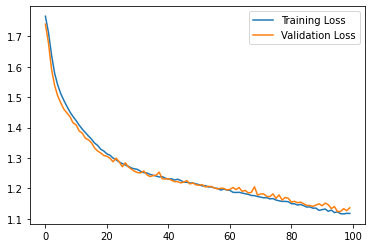

In [46]:
plt.plot(range(len(history.history["loss"])), history.history["loss"], label = "Training Loss")
plt.plot(range(len(history.history["val_loss"])), history.history["val_loss"], label = "Validation Loss")
plt.legend()

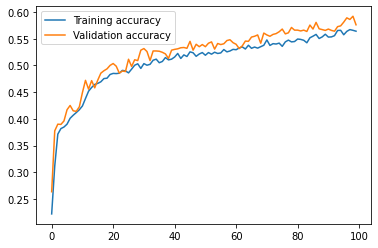

In [47]:
plt.plot(range(len(history.history["accuracy"])), history.history["accuracy"], label = "Training accuracy")
plt.plot(range(len(history.history["val_accuracy"])), history.history["val_accuracy"], label = "Validation accuracy")
plt.legend()

### First Model with Hjorth Features

In [55]:
hjorth_train, hjorth_test, y_train, y_test = train_test_split(hjorth_df, target, test_size = 0.4)

In [56]:
y_train = pd.DataFrame(y_train).reset_index()
y_test = pd.DataFrame(y_test).reset_index()

In [57]:
y_train = y_train.drop(columns = 'index')
y_test = y_test.drop(columns = 'index')

In [59]:
in_x = Input(shape = hjorth_train.shape[1:])
x = Dense(12, input_dim = hjorth_train.shape[1], activation = 'relu')(in_x)
x = Dense(8, activation = 'relu')(x)
x = Dense(8, activation = 'relu')(x)
out_x = Dense(6, activation = 'softmax')(x)

model2 = Model(in_x, out_x)

model2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 16)]              0         
                                                                 
 dense_8 (Dense)             (None, 12)                204       
                                                                 
 dense_9 (Dense)             (None, 8)                 104       
                                                                 
 dense_10 (Dense)            (None, 8)                 72        
                                                                 
 dense_11 (Dense)            (None, 6)                 54        
                                                                 
Total params: 434
Trainable params: 434
Non-trainable params: 0
_________________________________________________________________


In [60]:
model2.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [62]:
history=model2.fit(hjorth_train, 
                  y_train, 
                  validation_data = (hjorth_test, y_test), 
                  epochs = 100, batch_size = 10)

Epoch 1/100
300/300 [==============================] - 2s 3ms/step - loss: 1.9375 - accuracy: 0.2653 - val_loss: 1.7630 - val_accuracy: 0.3785
Epoch 2/100
300/300 [==============================] - 1s 2ms/step - loss: 1.7013 - accuracy: 0.3793 - val_loss: 1.6690 - val_accuracy: 0.3850
Epoch 3/100
300/300 [==============================] - 1s 3ms/step - loss: 1.6157 - accuracy: 0.3890 - val_loss: 1.6069 - val_accuracy: 0.3970
Epoch 4/100
300/300 [==============================] - 1s 2ms/step - loss: 1.5617 - accuracy: 0.4000 - val_loss: 1.5542 - val_accuracy: 0.4070
Epoch 5/100
300/300 [==============================] - 1s 2ms/step - loss: 1.5148 - accuracy: 0.4027 - val_loss: 1.5079 - val_accuracy: 0.4145
Epoch 6/100
300/300 [==============================] - 1s 2ms/step - loss: 1.4794 - accuracy: 0.4197 - val_loss: 1.4758 - val_accuracy: 0.4255
Epoch 7/100
300/300 [==============================] - 1s 2ms/step - loss: 1.4430 - accuracy: 0.4313 - val_loss: 1.4451 - val_accuracy: 0.4510

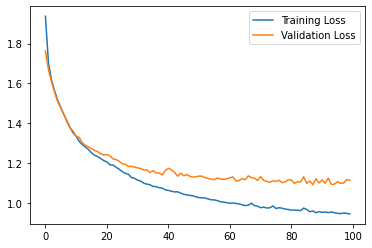

In [63]:
plt.plot(range(len(history.history["loss"])), history.history["loss"], label = "Training Loss")
plt.plot(range(len(history.history["val_loss"])), history.history["val_loss"], label = "Validation Loss")
plt.legend()

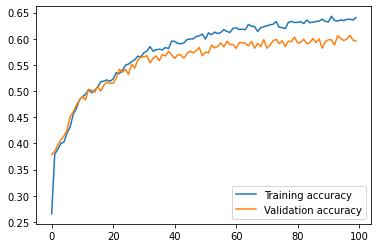

In [64]:
plt.plot(range(len(history.history["accuracy"])), history.history["accuracy"], label = "Training accuracy")
plt.plot(range(len(history.history["val_accuracy"])), history.history["val_accuracy"], label = "Validation accuracy")
plt.legend()

The Hjorth Features got better accuracy, so I'll use that dataframe moving forward.

### Second Model with Added Dense Layer

In [66]:
in_x = Input(shape = hjorth_train.shape[1:])
x = Dense(12, input_dim = hjorth_train.shape[1], activation = 'relu')(in_x)
x = Dense(10, activation = 'relu')(x)
x = Dense(8, activation = 'relu')(x)
x = Dense(8, activation = 'relu')(x)
out_x = Dense(6, activation ='softmax')(x)

model3 = Model(in_x, out_x)

model3.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 16)]              0         
                                                                 
 dense_17 (Dense)            (None, 12)                204       
                                                                 
 dense_18 (Dense)            (None, 10)                130       
                                                                 
 dense_19 (Dense)            (None, 8)                 88        
                                                                 
 dense_20 (Dense)            (None, 8)                 72        
                                                                 
 dense_21 (Dense)            (None, 6)                 54        
                                                                 
Total params: 548
Trainable params: 548
Non-trainable param

In [67]:
model3.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [68]:
history=model3.fit(hjorth_train, 
                  y_train, 
                  validation_data = (hjorth_test, y_test), 
                  epochs = 100, batch_size = 10)

Epoch 1/100
300/300 [==============================] - 2s 3ms/step - loss: 1.7961 - accuracy: 0.2810 - val_loss: 1.6969 - val_accuracy: 0.3605
Epoch 2/100
300/300 [==============================] - 1s 3ms/step - loss: 1.6454 - accuracy: 0.3833 - val_loss: 1.5727 - val_accuracy: 0.3995
Epoch 3/100
300/300 [==============================] - 1s 3ms/step - loss: 1.5355 - accuracy: 0.4153 - val_loss: 1.4782 - val_accuracy: 0.4330
Epoch 4/100
300/300 [==============================] - 1s 3ms/step - loss: 1.4656 - accuracy: 0.4263 - val_loss: 1.4460 - val_accuracy: 0.4300
Epoch 5/100
300/300 [==============================] - 1s 3ms/step - loss: 1.4239 - accuracy: 0.4403 - val_loss: 1.4040 - val_accuracy: 0.4560
Epoch 6/100
300/300 [==============================] - 1s 3ms/step - loss: 1.3929 - accuracy: 0.4600 - val_loss: 1.3960 - val_accuracy: 0.4655
Epoch 7/100
300/300 [==============================] - 1s 3ms/step - loss: 1.3818 - accuracy: 0.4713 - val_loss: 1.3805 - val_accuracy: 0.4730

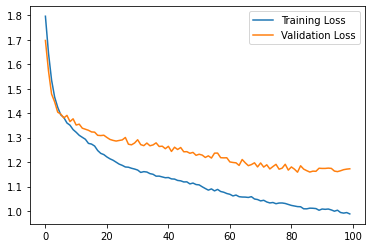

In [69]:
plt.plot(range(len(history.history["loss"])), history.history["loss"], label = "Training Loss")
plt.plot(range(len(history.history["val_loss"])), history.history["val_loss"], label = "Validation Loss")
plt.legend()

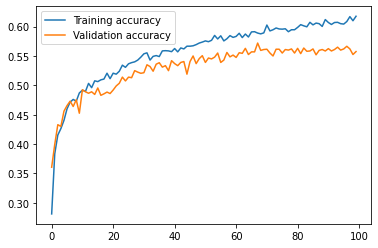

In [70]:
plt.plot(range(len(history.history["accuracy"])), history.history["accuracy"], label = "Training accuracy")
plt.plot(range(len(history.history["val_accuracy"])), history.history["val_accuracy"], label = "Validation accuracy")
plt.legend()

Larger divergence between training and validation loss. Happens earlier too. Accuracy performance fairly similar.

### Testing SGD Instead of Adam

In [74]:
in_x = Input(shape = hjorth_train.shape[1:])
x = Dense(12, input_dim = hjorth_train.shape[1], activation = 'relu')(in_x)
x = Dense(8, activation = 'relu')(x)
x = Dense(8, activation = 'relu')(x)
out_x = Dense(6, activation = 'softmax')(x)

model4 = Model(in_x, out_x)

model4.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 16)]              0         
                                                                 
 dense_30 (Dense)            (None, 12)                204       
                                                                 
 dense_31 (Dense)            (None, 8)                 104       
                                                                 
 dense_32 (Dense)            (None, 8)                 72        
                                                                 
 dense_33 (Dense)            (None, 6)                 54        
                                                                 
Total params: 434
Trainable params: 434
Non-trainable params: 0
_________________________________________________________________


In [76]:
model4.compile(loss = 'categorical_crossentropy', optimizer = 'sgd', metrics = ['accuracy'])

In [77]:
history=model4.fit(hjorth_train, 
                  y_train, 
                  validation_data = (hjorth_test, y_test), 
                  epochs = 100, batch_size = 10)

Epoch 1/100
300/300 [==============================] - 1s 3ms/step - loss: 1.7999 - accuracy: 0.2987 - val_loss: 1.7130 - val_accuracy: 0.3490
Epoch 2/100
300/300 [==============================] - 1s 3ms/step - loss: 1.7128 - accuracy: 0.3500 - val_loss: 1.6763 - val_accuracy: 0.3380
Epoch 3/100
300/300 [==============================] - 1s 3ms/step - loss: 1.6372 - accuracy: 0.3720 - val_loss: 1.6264 - val_accuracy: 0.3630
Epoch 4/100
300/300 [==============================] - 1s 3ms/step - loss: 1.5858 - accuracy: 0.3997 - val_loss: 1.5770 - val_accuracy: 0.4010
Epoch 5/100
300/300 [==============================] - 1s 3ms/step - loss: 1.5479 - accuracy: 0.4027 - val_loss: 1.5525 - val_accuracy: 0.3855
Epoch 6/100
300/300 [==============================] - 1s 3ms/step - loss: 1.5264 - accuracy: 0.4093 - val_loss: 1.5207 - val_accuracy: 0.4055
Epoch 7/100
300/300 [==============================] - 1s 3ms/step - loss: 1.5047 - accuracy: 0.4210 - val_loss: 1.4873 - val_accuracy: 0.4395

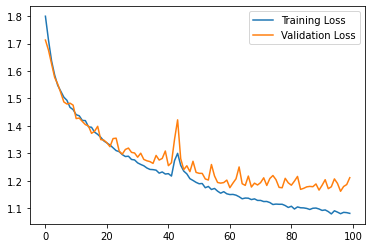

In [78]:
plt.plot(range(len(history.history["loss"])), history.history["loss"], label = "Training Loss")
plt.plot(range(len(history.history["val_loss"])), history.history["val_loss"], label = "Validation Loss")
plt.legend()

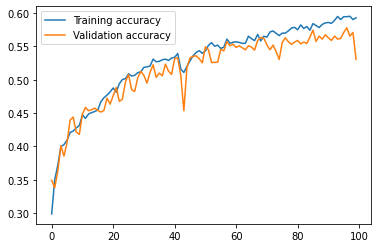

In [79]:
plt.plot(range(len(history.history["accuracy"])), history.history["accuracy"], label = "Training accuracy")
plt.plot(range(len(history.history["val_accuracy"])), history.history["val_accuracy"], label = "Validation accuracy")
plt.legend()

The accuracy with SGD was worse. The spike at about 45 epochs in both plots is interesting. Training and validation loss and accuracy don't diverge as much with SGD.